## Overview
A startup company is focusing on various ML solutions for European banking market.

*We want to develop a ML system leveraging call center data to improve the success rate for calls made to customers for the client's products -  
high success rate + interpretability for our clients to make informed decisions.*

**Recent survey data subset:**  

age = age of customer (numeric)  
job = type of job (categorical)  
marital = marital status (categorical)  
education = max education (categorical)  
default = has credit in default? (binary)  
balance = average yearly balance, in euros (numeric)  
housing = has a housing loan? (binary)  
loan = has personal loan? (binary)  
contact = contact communication type (categorical)  
day = last contact day of the month (numeric)  
month = last contact month of year (categorical)  
duration = last contact duration, in seconds (numeric)  
campaign = number of contacts performed during this campaign and for this client (numeric, includes last contact)  

y = has the client subscribed to a term deposit? (binary)

**Goals:**  

*Predict (e.g., >81% accuracy) if a customer will subscribe.* 

*Segment customers based on investment likelihood.*

*Determine features that most determine investment.*  

## Imports

In [369]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)

# For hyperparameter tuning
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, cross_val_score, KFold)

# For implementation
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import (SelectFromModel, SelectKBest, chi2)
from imblearn.over_sampling import (RandomOverSampler, SMOTE)

# For evaluation
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score)
from sklearn.metrics import (roc_curve, auc)

# For quickly testing models
from pycaret.classification import (setup, compare_models)

# Statistics
from scipy import stats
from scipy.stats import yeojohnson

# Feature inspection
from sklearn.inspection import permutation_importance

## Load data and explore

In [2]:
df = pd.read_csv('marketing.csv')
print('Shape is', df.shape)
df.head(3)

Shape is (40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no


In [3]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

In [4]:
# Are there any nans?

df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [26]:
# Create date column

cols=['month', 'day']
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str))+'-2021', axis="columns")
df['date']=pd.to_datetime(df['date'])
df['date'].sample(3)

36491   2021-05-12
2897    2021-05-14
7980    2021-06-02
Name: date, dtype: datetime64[ns]

In [27]:
# What are the basic statistics for each feature?

df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
age,40000.0,NaN,NaN,NaN,NaT,NaT,40.5446,9.641776,19.0,33.0,39.0,48.0,95.0
job,40000,12,blue-collar,9383,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,40000,3,married,24386,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,40000,4,secondary,20993,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,40000,2,no,39191,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,40000.0,NaN,NaN,NaN,NaT,NaT,1274.27755,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
housing,40000,2,yes,24031,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,40000,2,no,33070,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,40000,3,cellular,24914,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,40000.0,NaN,NaN,NaN,NaT,NaT,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0


Most customers have blue collar jobs, are married, finished secondary school, and presently have a housing loan.

#### Categorical data

In [148]:
# Examine categorical counts for object data grouped by y (invested or not)

# Separate the full dataset into invested (y = yes) and not invested (y = no)
dfy = df[df['y'] == 'yes'].reset_index(drop=True)
dfn = df[df['y'] == 'no'].reset_index(drop=True)

# Column list
cols = df.select_dtypes(include='object').columns

# Create dataframes
# For yes
dfy_counts = dfy[cols[0]].value_counts().reset_index()
dfy_counts.rename(columns={'index': cols[0]+'_ind'}, inplace=True)
# For no
dfn_counts = dfn[cols[0]].value_counts().reset_index()
dfn_counts.rename(columns={'index': cols[0]+'_ind'}, inplace=True)

# Add other columns to dataframe
for c in cols[1:]:
    # For yes
    a = dfy[c].value_counts().reset_index()
    a.rename(columns={'index': c+'_ind'}, inplace=True)
    dfy_counts = pd.concat([dfy_counts, a], axis=1)
    # For no
    b = dfn[c].value_counts().reset_index()
    b.rename(columns={'index': c+'_ind'}, inplace=True)
    dfn_counts = pd.concat([dfn_counts, b], axis=1)

# Divide by total number of yes/no customers
cols = dfy_counts.select_dtypes(include='number').columns
for c in cols:
    dfy_counts[c] = dfy_counts[c]/dfy_counts['y'].max()*100
    dfn_counts[c] = dfn_counts[c]/dfn_counts['y'].max()*100

print('Percentages of Customers who Invested:')
display(dfy_counts.head())
print('\nPercentages of Customers who did not Invest:')
display(dfn_counts.head())

Percentages of Customers who Invested:


,job_ind,job,marital_ind,marital,education_ind,education,default_ind,default,housing_ind,housing,loan_ind,loan,contact_ind,contact,month_ind,month,y_ind,y
0,management,23.342541,married,51.035912,secondary,48.964088,no,98.308011,yes,50.552486,no,86.878453,cellular,77.106354,may,27.313536,yes,100.0
1,blue-collar,18.473757,single,35.462707,tertiary,35.531768,yes,1.691989,no,49.447514,yes,13.121547,unknown,17.161602,apr,15.573204,NaN,NaN
2,technician,17.161602,divorced,13.501381,primary,12.189227,NaN,NaN,NaN,NaN,NaN,NaN,telephone,5.732044,jul,13.259669,NaN,NaN
3,admin,12.120166,NaN,NaN,unknown,3.314917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jun,10.151934,NaN,NaN
4,services,8.218232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,aug,9.944751,NaN,NaN



Percentages of Customers who did not Invest:


,job_ind,job,marital_ind,marital,education_ind,education,default_ind,default,housing_ind,housing,loan_ind,loan,contact_ind,contact,month_ind,month,y_ind,y
0,blue-collar,23.846486,married,61.739974,secondary,52.757115,no,97.951703,yes,60.820936,no,82.346917,cellular,61.128180,may,34.338616,no,100.0
1,management,20.186503,single,26.579345,tertiary,27.428310,yes,2.048297,no,39.179064,yes,17.653083,unknown,33.063821,jul,16.159983,NaN,NaN
2,technician,17.127533,divorced,11.680681,primary,15.947068,NaN,NaN,NaN,NaN,NaN,NaN,telephone,5.807999,aug,13.278892,NaN,NaN
3,admin,11.136266,NaN,NaN,unknown,3.867508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jun,11.966365,NaN,NaN
4,services,9.896507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nov,9.104140,NaN,NaN


Now we see the differences in relative populations among investors and noninvestors by feature. Some of the important features (exhibiting clear differences) appear to be job, marital, education, housing loan, and apparently even the contact method.

In [289]:
corr['y'].drop('y').index

Index(['job_admin', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct'],
      dtype='object')

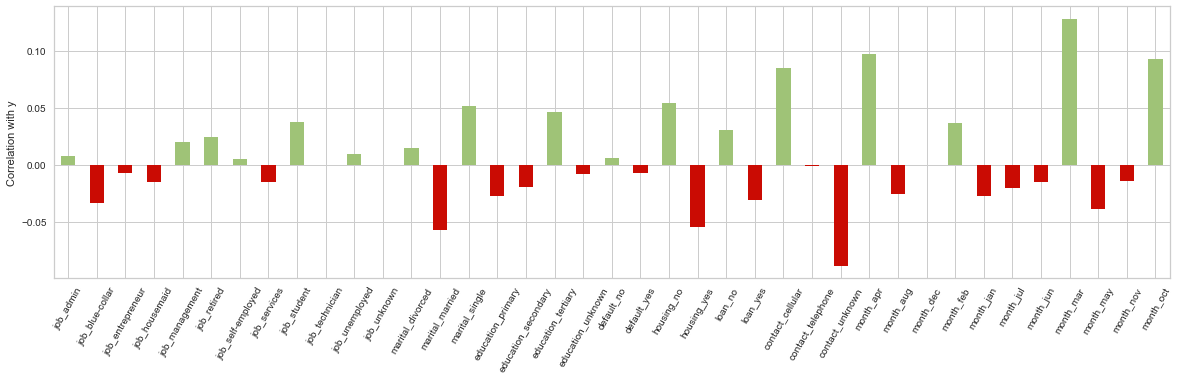

In [291]:
# Make y binary

df1 = df.select_dtypes(include='object').copy()
df1['y'] = df1['y'].map(dict(yes=1, no=0))

# Onehot

df1 = pd.get_dummies(df1, 
                     columns=['job', 
                              'marital', 
                              'education', 
                              'default', 
                              'housing', 
                              'loan', 
                              'contact', 
                              'month'], 
                     drop_first = False)

# Create correlation matrix

corr = df1.corr()

# Series of interest

s = corr['y'].drop('y')

# Plot correlations

plt.figure(figsize=(20,5))
s.plot(kind='bar', color=(s > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(s)), labels=s.index)
plt.ylabel('Correlation with y')
plt.show()

In [303]:
print('The number of features from the 39 above with correlation coefficient, '
      f'-0.01 < r < 0.01, is {(np.abs(s) < .01).sum()}.')
print()
print('The number of features from the 39 above with correlation coefficient, '
      f'-0.02 < r < 0.02, is {(np.abs(s) < .02).sum()}.')

The number of features from the 39 above with correlation coefficient, -0.01 < r < 0.01, is 11.

The number of features from the 39 above with correlation coefficient, -0.02 < r < 0.02, is 17.


Almost half of the 39 features above show very little correlation with y. Clearly, certain features show much stronger correlations (-0.05 < r < 0.05). One example is the month of March, over against December.

#### Numerical data

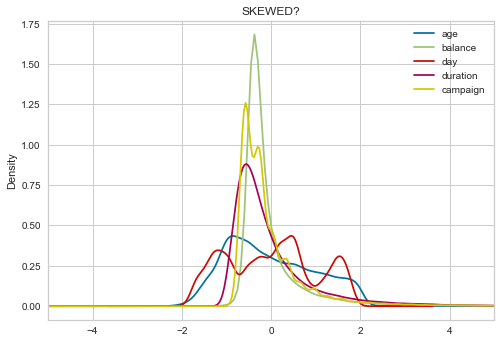

In [195]:
# Examine distributions for numerical data

# Numerical data
dfnum = df.select_dtypes('number')

# Normalize (standard scaler)
for c in dfnum.columns:
    dfnum[c] = (dfnum[c] - dfnum[c].mean())/dfnum[c].std()

# Plot
ax = dfnum.plot(kind='kde', title='SKEWED?')
ax.set_xlim(-5, 5)
plt.show()

In [196]:
# Calculation of feature skewness

skew_vals = dfnum.skew()
skew_vals.sort_values(ascending = False)

balance     8.259236
campaign    4.730901
duration    3.165307
age         0.436080
day         0.067930
dtype: float64

The balance, campaign, and duration are significantly skewed to the right. The age is also positively skewed. The day is roughly normal.

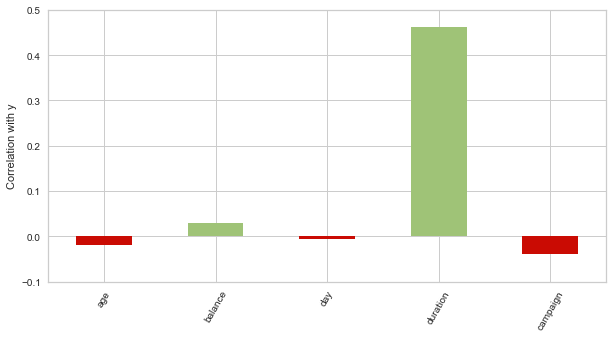

In [313]:
# Correlation matrix

dfnum['y'] = df['y']
dfnum['y'] = dfnum['y'].map(dict(yes=1, no=0))
corr = dfnum.corr()

# Plot correlations

plt.figure(figsize=(10,5))
corr['y'].drop('y').plot(kind='bar', 
                         color=(corr['y'] > 0).map({True: 'g', False: 'r'}))
plt.xticks(rotation=60)
plt.xticks(np.arange(len(corr.index)-1), labels=corr.drop('y').index)
plt.ylabel('Correlation with y')
plt.ylim(-0.1, 0.5)
plt.show()

The weakest correlation with y is the day of the month. Other weakly linked features are age, balance, and campaign.

## Feature Engineering

In [329]:
# Remove onehot variables with low correlation coefficients

# Subset of feature names
cols = list(s[np.abs(s) > .02].index)
# Subset of dataframe
dfcat = df1[cols]
dfcat.head(2)

,job_blue-collar,job_management,job_retired,job_student,marital_married,marital_single,education_primary,education_tertiary,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_unknown,month_apr,month_aug,month_feb,month_jan,month_jul,month_mar,month_may,month_oct
0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0


Skew:
balance     1.058649
campaign    0.213011
day         0.067930
duration    0.013301
age         0.001901
dtype: float64


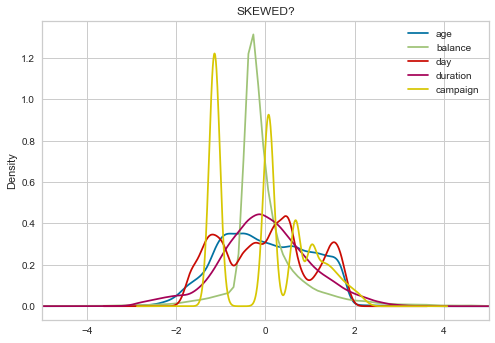

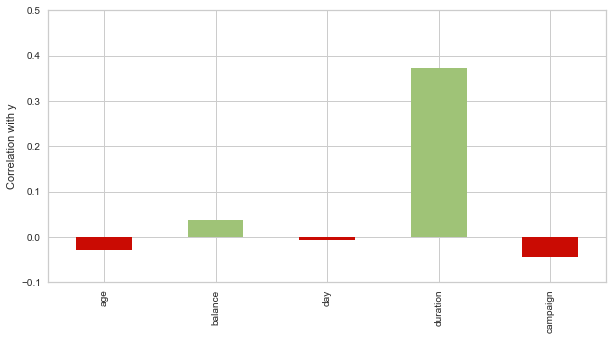

In [314]:
# Remove some skewness of continuous variables via the Yeo Johnson transformation

# Numerical data
dfnum = df.select_dtypes('number')

# Transform and make dataframe
age_tra, age_lambda = yeojohnson(dfnum['age'])
bal_tra, bal_lambda = yeojohnson(dfnum['balance'])
dur_tra, dur_lambda = yeojohnson(dfnum['duration'])
camp_tra, camp_lambda = yeojohnson(dfnum['campaign'])
dfnumy_tra = dfnum.copy()
dfnumy_tra['age'] = age_tra
dfnumy_tra['balance'] = bal_tra
dfnumy_tra['duration'] = dur_tra
dfnumy_tra['campaign'] = camp_tra

# Normalize (standard scaler)
for c in dfnumy_tra.columns:
    dfnumy_tra[c] = (dfnumy_tra[c] - dfnumy_tra[c].mean())/dfnumy_tra[c].std()
    
# Recalculation of feature skewness
skew_vals = dfnumy_tra.skew()
print('Skew:')
print(skew_vals.sort_values(ascending = False))

# Plot distributions for transformed data
ax = dfnumy_tra.plot(kind='kde', title='SKEWED?')
ax.set_xlim(-5, 5)
plt.show()

# Replot correlation matrix
dfnumy_tra['y'] = df['y']
dfnumy_tra['y'] = dfnumy_tra['y'].map(dict(yes=1, no=0))
corr = dfnumy_tra.corr()
plt.figure(figsize=(10,5))
corr['y'].drop('y').plot(kind='bar', 
                         color=(corr['y'] > 0).map({True: 'g', False: 'r'}))
plt.xticks(np.arange(len(corr.index)-1), labels=corr.drop('y').index)
plt.ylabel('Correlation with y')
plt.ylim(-0.1, 0.5)
plt.show()

Weak correlations between y and have improved for age, balance, and campaign.

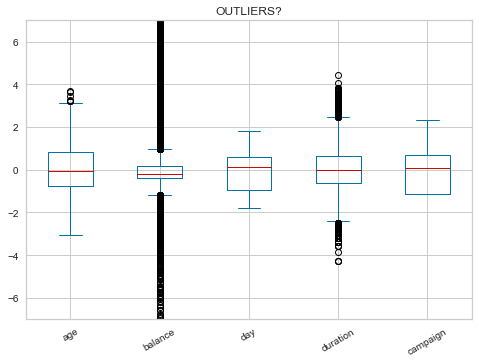

In [308]:
# Are there many outliers in the continuous variables?

dfnumy_tra.iloc[:,:-1].plot(kind='box', title='OUTLIERS?')
plt.xticks(rotation=30)
plt.ylim(-7, 7)
plt.show()

Large number of outliers for balance and duration. However, they are found on either side of the mean. For now, we will keep them.

In [350]:
# Put together final raw dataset

df_raw = pd.concat([dfcat, dfnumy_tra], axis=1, ignore_index=True)
df_raw.columns = list(dfcat.columns) + list(dfnumy_tra.columns)
df_raw.head(2)

,job_blue-collar,job_management,job_retired,job_student,marital_married,marital_single,education_primary,education_tertiary,housing_no,housing_yes,...,month_jul,month_mar,month_may,month_oct,age,balance,day,duration,campaign,y
0,0,1,0,0,1,0,0,1,0,1,...,0,0,1,0,1.625065,0.456660,-1.330884,0.413927,-1.140491,0
1,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0.463595,-0.387473,-1.330884,-0.189364,-1.140491,0


We have 21 columns of onehot encoded variables, 5 continuous variable, and 1 dependent variable.

#### Resampling to deal with class imbalance

In [351]:
# Create the 2 class-specific dataframes

df_invest = df_raw[df_raw['y'] == 1].reset_index(drop=True)
df_notinvest = df_raw[df_raw['y'] == 0].reset_index(drop=True)

print(f'There are {len(df_invest)} investors and {len(df_notinvest)} that did not invest.')

There are 2896 investors and 37104 that did not invest.


In [354]:
# We will first try random downsampling (without replacement) 
# to match the class sizes of the noninvestors and investors. 

df_notinvest_s = df_notinvest.sample(n=len(df_invest), random_state=0)

# Combine classes for our small dataframe

df_small = pd.concat([df_invest, df_notinvest_s], axis=0).reset_index(drop=True)
df_small.shape

(5792, 28)

In [355]:
# We will also try random upsampling (with replacement)
# to match the class sizes.

df_invest_s = df_invest.sample(n=len(df_notinvest), replace=True, random_state=0)

# Combine classes for our large dataframe

df_large = pd.concat([df_invest_s, df_notinvest], axis=0).reset_index(drop=True)
df_large.shape

(74208, 28)

Besides these, we might also try upsampling with SMOTE. For now, we will see how the classifiers perform.

## Model exploration

We use pycaret on the balanced datasets.  
(I also tried pycaret on the imbalanced data using the setup option 'fix_imbalance=True', but it did not perform well.)

In [361]:
# Although pycaret will perform a train, test split, we should set aside an
# "official test set" beforehand to facilitate a rigorous evaluation of our final model.
# Thus, pycaret will be splittng the training set.

# Train, test split

# Imbalanced dataset
# y = df_use['y'].to_numpy()
# X = df1.iloc[:,1:].to_numpy()
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=333)

# Small balanced dataset
ysm = df_small['y'].to_numpy()
Xsm = df_small.iloc[:,:-1].to_numpy()
X_tr_sm, X_te_sm, y_tr_sm, y_te_sm = train_test_split(Xsm, ysm, test_size=0.3, random_state=333)

# Large balanced dataset
yla = df_large['y'].to_numpy()
Xla = df_large.iloc[:,:-1].to_numpy()
X_tr_la, X_te_la, y_tr_la, y_te_la = train_test_split(Xla, yla, test_size=0.3, random_state=333)

In [362]:
# Build dataframe from training set for pycaret testing of models

# Imbalanced
# df_train = pd.DataFrame(X_train)
# df_train['y'] = y_train

# Small balanced
df_train_sm = pd.DataFrame(X_tr_sm)
df_train_sm['y'] = y_tr_sm

# Large balanced
df_train_la = pd.DataFrame(X_tr_la)
df_train_la['y'] = y_tr_la

In [363]:
# Setup pycaret and compare models for full dataset
# s = setup(df_train, 
#           target='y', 
#           fix_imbalance=True, 
#           html=False, 
#           silent=True, 
#           verbose=False)
# best = compare_models()
# print(best)

# Setup pycaret and compare models for small balanced dataset
s = setup(df_train_sm, 
          target='y', 
          html=False, 
          silent=True, 
          verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006
qda,Quadratic Discriminant Analysis,0.5114,0.5087,0.2961,0.2082,0.2347,0.0174,0.0175,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
ada,Ada Boost Classifier,0.8608,0.9257,0.8460,0.8709,0.8572,0.7214,0.7234,0.057
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006
qda,Quadratic Discriminant Analysis,0.5114,0.5087,0.2961,0.2082,0.2347,0.0174,0.0175,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
gbc,Gradient Boosting Classifier,0.8678,0.9365,0.8717,0.8639,0.8669,0.7356,0.7371,0.118
ada,Ada Boost Classifier,0.8608,0.9257,0.8460,0.8709,0.8572,0.7214,0.7234,0.057
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006
qda,Quadratic Discriminant Analysis,0.5114,0.5087,0.2961,0.2082,0.2347,0.0174,0.0175,0.008


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
gbc,Gradient Boosting Classifier,0.8678,0.9365,0.8717,0.8639,0.8669,0.7356,0.7371,0.118
ada,Ada Boost Classifier,0.8608,0.9257,0.8460,0.8709,0.8572,0.7214,0.7234,0.057
lda,Linear Discriminant Analysis,0.8488,0.9271,0.8917,0.8198,0.8537,0.6978,0.7016,0.009
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009
nb,Naive Bayes,0.6729,0.8415,0.4312,0.8237,0.5645,0.3423,0.3889,0.006


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
gbc,Gradient Boosting Classifier,0.8678,0.9365,0.8717,0.8639,0.8669,0.7356,0.7371,0.118
ada,Ada Boost Classifier,0.8608,0.9257,0.8460,0.8709,0.8572,0.7214,0.7234,0.057
et,Extra Trees Classifier,0.8586,0.9250,0.8596,0.8564,0.8575,0.7173,0.7181,0.125
lda,Linear Discriminant Analysis,0.8488,0.9271,0.8917,0.8198,0.8537,0.6978,0.7016,0.009
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030
dt,Decision Tree Classifier,0.8209,0.8209,0.8189,0.8190,0.8186,0.6418,0.6423,0.009


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8851,0.9381,0.8974,0.8749,0.8854,0.7702,0.7715,0.033
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
gbc,Gradient Boosting Classifier,0.8678,0.9365,0.8717,0.8639,0.8669,0.7356,0.7371,0.118
ada,Ada Boost Classifier,0.8608,0.9257,0.8460,0.8709,0.8572,0.7214,0.7234,0.057
et,Extra Trees Classifier,0.8586,0.9250,0.8596,0.8564,0.8575,0.7173,0.7181,0.125
lda,Linear Discriminant Analysis,0.8488,0.9271,0.8917,0.8198,0.8537,0.6978,0.7016,0.009
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8851,0.9381,0.8974,0.8749,0.8854,0.7702,0.7715,0.033
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
gbc,Gradient Boosting Classifier,0.8678,0.9365,0.8717,0.8639,0.8669,0.7356,0.7371,0.118
ada,Ada Boost Classifier,0.8608,0.9257,0.8460,0.8709,0.8572,0.7214,0.7234,0.057
et,Extra Trees Classifier,0.8586,0.9250,0.8596,0.8564,0.8575,0.7173,0.7181,0.125
lda,Linear Discriminant Analysis,0.8488,0.9271,0.8917,0.8198,0.8537,0.6978,0.7016,0.009
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8851,0.9381,0.8974,0.8749,0.8854,0.7702,0.7715,0.033
rf,Random Forest Classifier,0.8741,0.9336,0.8824,0.8674,0.8742,0.7483,0.7496,0.137
gbc,Gradient Boosting Classifier,0.8678,0.9365,0.8717,0.8639,0.8669,0.7356,0.7371,0.118
ada,Ada Boost Classifier,0.8608,0.9257,0.8460,0.8709,0.8572,0.7214,0.7234,0.057
et,Extra Trees Classifier,0.8586,0.9250,0.8596,0.8564,0.8575,0.7173,0.7181,0.125
lda,Linear Discriminant Analysis,0.8488,0.9271,0.8917,0.8198,0.8537,0.6978,0.7016,0.009
lr,Logistic Regression,0.8481,0.9271,0.8667,0.8336,0.8493,0.6962,0.6977,0.014
ridge,Ridge Classifier,0.8481,0.0000,0.8910,0.8191,0.8530,0.6964,0.7002,0.006
svm,SVM - Linear Kernel,0.8382,0.0000,0.8676,0.8236,0.8394,0.6766,0.6871,0.010
knn,K Neighbors Classifier,0.8325,0.8966,0.8233,0.8363,0.8290,0.6650,0.6662,0.030


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8501, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [364]:
# Setup pycaret and compare models for large balanced dataset
s = setup(df_train_la, 
          target='y', 
          html=False, 
          silent=True, 
          verbose=False)
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.855,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066
qda,Quadratic Discriminant Analysis,0.6669,0.8766,0.4162,0.8340,0.5552,0.3335,0.3854,0.040
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
ada,Ada Boost Classifier,0.8632,0.9328,0.8561,0.8683,0.8621,0.7264,0.7265,0.346
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066
qda,Quadratic Discriminant Analysis,0.6669,0.8766,0.4162,0.8340,0.5552,0.3335,0.3854,0.040
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
gbc,Gradient Boosting Classifier,0.8849,0.9458,0.9048,0.8701,0.8871,0.7699,0.7705,1.246
ada,Ada Boost Classifier,0.8632,0.9328,0.8561,0.8683,0.8621,0.7264,0.7265,0.346
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066
qda,Quadratic Discriminant Analysis,0.6669,0.8766,0.4162,0.8340,0.5552,0.3335,0.3854,0.040
nb,Naive Bayes,0.6456,0.8372,0.3918,0.7950,0.5249,0.2909,0.3375,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
gbc,Gradient Boosting Classifier,0.8849,0.9458,0.9048,0.8701,0.8871,0.7699,0.7705,1.246
ada,Ada Boost Classifier,0.8632,0.9328,0.8561,0.8683,0.8621,0.7264,0.7265,0.346
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lda,Linear Discriminant Analysis,0.8562,0.9253,0.8928,0.8318,0.8612,0.7125,0.7144,0.124
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066
qda,Quadratic Discriminant Analysis,0.6669,0.8766,0.4162,0.8340,0.5552,0.3335,0.3854,0.040


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9812,0.9998,0.9981,0.9656,0.9815,0.9625,0.9630,1.274
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
gbc,Gradient Boosting Classifier,0.8849,0.9458,0.9048,0.8701,0.8871,0.7699,0.7705,1.246
ada,Ada Boost Classifier,0.8632,0.9328,0.8561,0.8683,0.8621,0.7264,0.7265,0.346
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lda,Linear Discriminant Analysis,0.8562,0.9253,0.8928,0.8318,0.8612,0.7125,0.7144,0.124
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119
svm,SVM - Linear Kernel,0.8493,0.0000,0.8455,0.8529,0.8484,0.6986,0.7000,0.066


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9812,0.9998,0.9981,0.9656,0.9815,0.9625,0.9630,1.274
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
lightgbm,Light Gradient Boosting Machine,0.9218,0.9661,0.9634,0.8893,0.9249,0.8436,0.8465,0.227
gbc,Gradient Boosting Classifier,0.8849,0.9458,0.9048,0.8701,0.8871,0.7699,0.7705,1.246
ada,Ada Boost Classifier,0.8632,0.9328,0.8561,0.8683,0.8621,0.7264,0.7265,0.346
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lda,Linear Discriminant Analysis,0.8562,0.9253,0.8928,0.8318,0.8612,0.7125,0.7144,0.124
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9812,0.9998,0.9981,0.9656,0.9815,0.9625,0.9630,1.274
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
lightgbm,Light Gradient Boosting Machine,0.9218,0.9661,0.9634,0.8893,0.9249,0.8436,0.8465,0.227
gbc,Gradient Boosting Classifier,0.8849,0.9458,0.9048,0.8701,0.8871,0.7699,0.7705,1.246
ada,Ada Boost Classifier,0.8632,0.9328,0.8561,0.8683,0.8621,0.7264,0.7265,0.346
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lda,Linear Discriminant Analysis,0.8562,0.9253,0.8928,0.8318,0.8612,0.7125,0.7144,0.124
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9812,0.9998,0.9981,0.9656,0.9815,0.9625,0.9630,1.274
rf,Random Forest Classifier,0.9681,0.9996,0.9990,0.9409,0.9690,0.9362,0.9380,0.739
dt,Decision Tree Classifier,0.9652,0.9652,0.9985,0.9362,0.9663,0.9304,0.9325,0.072
knn,K Neighbors Classifier,0.9236,0.9626,0.9834,0.8783,0.9279,0.8472,0.8534,0.613
lightgbm,Light Gradient Boosting Machine,0.9218,0.9661,0.9634,0.8893,0.9249,0.8436,0.8465,0.227
gbc,Gradient Boosting Classifier,0.8849,0.9458,0.9048,0.8701,0.8871,0.7699,0.7705,1.246
ada,Ada Boost Classifier,0.8632,0.9328,0.8561,0.8683,0.8621,0.7264,0.7265,0.346
ridge,Ridge Classifier,0.8562,0.0000,0.8928,0.8319,0.8612,0.7125,0.7145,0.025
lda,Linear Discriminant Analysis,0.8562,0.9253,0.8928,0.8318,0.8612,0.7125,0.7144,0.124
lr,Logistic Regression,0.8550,0.9256,0.8728,0.8428,0.8575,0.7101,0.7106,0.119


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6454, verbose=0,
                     warm_start=False)


The large dataset yields much higher scores. We will see if we can optimize the Extra Trees and Random Forest classifiers for the large dataset.

## Modeling

In [365]:
# Instantiate

rfc = RandomForestClassifier()

# Define parameter grid

rfc_par_grid = {'n_estimators': [100, 1000],
               'max_depth': [5, 10, 50, None],
               'min_samples_split': [2, 5, 10],
               'bootstrap': [True, False]}

# Define grid

rfc_grid = RandomizedSearchCV(estimator=rfc,  
                              param_distributions=rfc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=100, 
                              random_state=9)

# Fitting full dataset

rfc_grid.fit(X_tr_la, y_tr_la)
print(f'Best parameters are {rfc_grid.best_params_}\n')
print(f'Best score is {rfc_grid.best_score_}\n')

# Predict

rfc_grid_pred = rfc_grid.predict(X_te_la)

# Classification report

print(classification_report(y_te_la, rfc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(y_te_la, 
                               rfc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 17.4min finished


Best parameters are {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 50, 'bootstrap': False}

Best score is 0.9783617287515641

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     11217
           1       0.97      1.00      0.99     11046

    accuracy                           0.99     22263
   macro avg       0.99      0.99      0.99     22263
weighted avg       0.99      0.99      0.99     22263



Predicted,0,1
Actual,,
0,10919,298
1,0,11046


#### Random Forest

Random Forest really did well, achieving 99% accuracy (as opposed to an already high 93% accuracy choosing 'no' every time for the imbalanced dataset).  
This classifier identified all investors (no false negatives), but reported 298 false positives.

#### Extra Trees

In [366]:
# Instantiate

etc = ExtraTreesClassifier()

# Define parameter grid

etc_par_grid = {'bootstrap': [True, False], 
                 'n_estimators': [20, 100, 500, 1000],
                 'max_features': [2, 3, 4, 5], 
                 'min_samples_split': [2, 4, 6],
                 'max_depth': [2, 3, 5, 10, 20]
                 }

# Define grid - use random search since the grid is large (faster than GridSearch)

etc_grid = RandomizedSearchCV(estimator=etc,  
                              param_distributions=etc_par_grid, 
                              cv = 3, 
                              refit=True, 
                              verbose=2, 
                              n_jobs=-1, 
                              n_iter=100,
                              random_state=9)

# Fitting

etc_grid.fit(X_tr_la, y_tr_la)
print(f'Best parameters are {etc_grid.best_params_}\n')
print(f'Best score is {etc_grid.best_score_}\n')

# Predict

etc_grid_pred = etc_grid.predict(X_te_la)

# Classification report

print(classification_report(y_te_la, etc_grid_pred))

# Confusion matrix

confusion_matrix = pd.crosstab(y_te_la, 
                               etc_grid_pred, 
                               rownames=['Actual'], 
                               colnames=['Predicted'])
confusion_matrix

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.4min finished


Best parameters are {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 2, 'max_depth': 20, 'bootstrap': False}

Best score is 0.9693714505727211

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     11217
           1       0.96      0.99      0.97     11046

    accuracy                           0.97     22263
   macro avg       0.97      0.97      0.97     22263
weighted avg       0.97      0.97      0.97     22263



Predicted,0,1
Actual,,
0,10712,505
1,127,10919


Extra Trees did not do quite as well as Random Forest.

## K-fold Cross Validation for Random Forest

In [371]:
kfold = KFold(n_splits=5, shuffle=True, random_state=5)

rfc_fin = RandomForestClassifier(n_estimators=100, 
                                 min_samples_split=2, 
                                 max_depth=50, 
                                 bootstrap=False, 
                                 random_state=5)

result = cross_val_score(estimator=rfc_fin, 
                         X=X_tr_la, 
                         y=y_tr_la, 
                         cv=kfold, 
                         scoring='accuracy')

In [383]:
print('The average score (for accuracy) during 5-fold cross-validation is '
      f'{100*np.mean(result):.4}% +/- {100*np.std(result):.2}%.')

The average score (for accuracy) during 5-fold cross-validation is 98.24% +/- 0.052%.


## Predictions

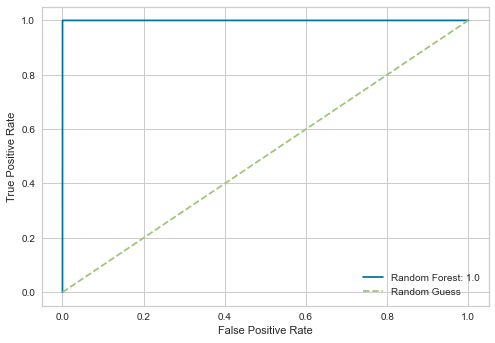

In [385]:
# Fitting

rfc_fin.fit(X_tr_la, y_tr_la)

# Predict the probabilities for investing

pred_proba = rfc_fin.predict_proba(X_te_la)[:,1]

# Get the false and true positive rates

fpr, tpr, threshold = roc_curve(y_te_la, pred_proba)

# Area under curve

roc_auc = auc(fpr, tpr)

# Plot  ROC curve

plt.plot(fpr, tpr)
# plt.plot([0,1], [0,1], '--') # put in dummy classifier baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([f'Random Forest: {roc_auc:.4}', 'Random Guess'])
plt.show()

In [389]:
# Permutation test to determine and record feature importances

# I used ~3 times the number of features for n_repeats (this step takes several minutes).

# Instantiate
r = permutation_importance(rfc_fin, X_te_la, y_te_la, n_repeats=100, random_state=9)

# Dictionary for features and importances
feat = {}  

# Carry out the permutation
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        feat[df_large.columns[i]] = [r.importances_mean[i], r.importances_std[i]]

# Print results
for k, v in feat.items():     
    print(f'{k:<20}'
          f'mean: {v[0]:.3f}'
          f' +/- {v[1]:.3f}')

duration            mean: 0.342 +/- 0.002
day                 mean: 0.078 +/- 0.001
balance             mean: 0.068 +/- 0.001
month_apr           mean: 0.052 +/- 0.001
age                 mean: 0.049 +/- 0.001
contact_cellular    mean: 0.040 +/- 0.001
month_may           mean: 0.035 +/- 0.001
contact_unknown     mean: 0.032 +/- 0.001
campaign            mean: 0.031 +/- 0.001
marital_married     mean: 0.029 +/- 0.001
month_mar           mean: 0.018 +/- 0.000
month_feb           mean: 0.018 +/- 0.000
education_tertiary  mean: 0.014 +/- 0.001
marital_single      mean: 0.011 +/- 0.001
month_aug           mean: 0.010 +/- 0.000
month_jul           mean: 0.008 +/- 0.000
month_oct           mean: 0.007 +/- 0.000
job_blue-collar     mean: 0.006 +/- 0.000
education_primary   mean: 0.003 +/- 0.000
job_management      mean: 0.003 +/- 0.000
housing_yes         mean: 0.002 +/- 0.000
month_jan           mean: 0.001 +/- 0.000
job_student         mean: 0.000 +/- 0.000


Duration of the last call with the customer, as expected from data exploration, is the main predictor for the model.  
After this, we have day of the month as a somewhat surprisingly important feature. On this note, the months of May and April seem to be good times to attract an investor.   
Average yearly balance and age of the customer are also high on the list, which are logical factors to consider.

## Customer Segmentation

## Conclusion

We used a Random Forest Classifier to achieve an accuracy of 99%, with F1-scores of 0.99 for both classes. 

The most impactful features were the...